In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import time
import Pulser
from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import ConstantWaveform, RampWaveform, CustomWaveform
from pulser.devices import Chadoq2
from pulser.simresults import SimulationResults

from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
from skopt import gp_minimize
from skopt import callbacks
from skopt.utils import cook_initial_point_generator

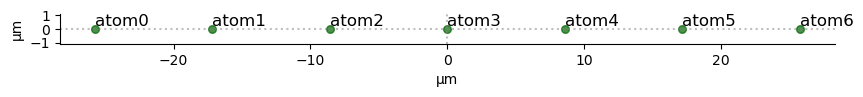

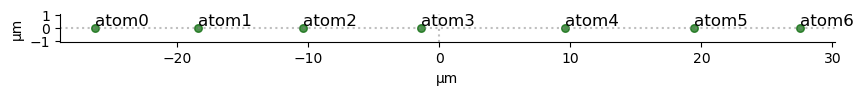

In [3]:
# Parameters in MHz and ns
U_0 = 2 * np.pi * 2.0

Omega_max = 1.5 * U_0 

delta_0 = -2 * U_0
delta_f = 1.8 * U_0 

def reg(N, W):
    U =  [U_0 * (1 + np.random.uniform(-W, W)) for _ in range(N)]
    w = [u/U_0-1 for u in U]
    def R(j):
        return Chadoq2.rydberg_blockade_radius(U[j]) 

    # Build Register:

    coords = np.array([(sum(R(k) for k in range(i)), 0.) for i in range(N)])
    return Register.from_coordinates(coords, prefix='atom'),w

N = 7
W = 0.83
reg9,w = reg(N,W)
REG,w = reg (N,0)
N_samples = 1000
REG.draw()
reg9.draw()
seq_init = Sequence(REG, Chadoq2)
seq_init.declare_channel('ising', 'rydberg_global')

In [19]:
Chadoq2.rydberg_blockade_radius(Omega_max)

8.018088350071375

In [1]:
Chadoq2.rydberg_blockade_radius(U_0)
U_0-W > Omega_max


NameError: name 'Chadoq2' is not defined

## Optimised ramp pulses for undisturbed chain


In [91]:
delta_0 = -2 * 2*np.pi
delta_f = 1.8 * 2*np.pi
Omega_max = seq_init.declared_channels['ising'].max_amp

T = 8000

In [92]:
def ramp_seq(regist, para):
    t_rise = int(para[0]*T/sum(para))
    t_sweep = int(para[1]*T/sum(para))
    t_fall = int(para[2]*T/sum(para))
    
    rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
    sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
    fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

    sequence = Sequence(regist, Chadoq2)
    sequence.declare_channel('ising', 'rydberg_global')

    sequence.add(rise, 'ising')
    sequence.add(sweep, 'ising')
    sequence.add(fall, 'ising')
    
    
    return sequence

In [127]:
K = 1000
REGG = [reg(N,W) for i in range(K)]
REGGG = [r[0] for r in REGG]
WW = [w[1] for w  in REGG]
para = RESULT_ramp.x
STATES = [stg_mag(ramp_state(r,para)) for r in REGGG]

In [128]:
RES=[]
for i in range(K):
    if STATES[i]>=6:
        RES.append(WW[i])
print(len(RES))

536


In [130]:
print(sum(np.mean(WW,axis=0))/N)
print(sum(np.var(WW,axis=0))/N-(2*W)**2/12)

print(sum(np.mean(WW[:len(RES)],axis=0))/N)
print(sum(np.var(WW[:len(RES)],axis=0))/N-(2*W)**2/12)

print(sum(np.mean(RES,axis=0))/N)
print(sum(np.var(RES,axis=0))/N-(2*W)**2/12)

-0.005240512644419648
-0.003649154329294857
0.0024619791851349824
-0.007661907323127659
0.07394735528700001
-0.03892550942705794


In [119]:
def ramp_state(regist,para):
    seq = ramp_seq(regist, para)
    simul = Simulation(seq,sampling_rate=0.1)
    results = simul.run()
    return results.states[-1]

In [120]:
def score_ramp(para):
    seq = ramp_seq(REG, para)
    simul = Simulation(seq, sampling_rate=0.2)
    results = simul.run()
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    F = sum([(-1)**j*expect_val[j][-1] for j in range(N)])/N
    #final = results.states[-1]
    
    #study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
    #sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
    #sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
    #frequencies = 0
    #if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
        #frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
    return (1 - F)

In [121]:
bounds_ramp = [(16*3,T)]*3

In [122]:
RESULT_ramp = gp_minimize(score_ramp,bounds_ramp,n_random_starts=40, n_calls=90, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5806
Function value obtained: 0.0919
Current minimum: 0.0919
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6453
Function value obtained: 0.0500
Current minimum: 0.0500
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6223
Function value obtained: 0.0271
Current minimum: 0.0271
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6533
Function value obtained: 0.0729
Current minimum: 0.0271
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5705
Function value obtained: 0.2671
Current minimum: 0.0271
Iteration No: 6 started. Evaluating

In [14]:
RESULT_ramp.x

[3156, 848, 5101]

In [16]:
regN = reg(N,W)
def score_ramp(para):
    seq = ramp_seq(regN, para)
    simul = Simulation(seq, sampling_rate=0.2)
    results = simul.run()
    final = results.states[-1]
    study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
    sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
    sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
    frequencies = 0
    if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
        frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
    return (1 - frequencies)
t1 = time.process_time()
best_find = minimize(score_ramp, x0=RESULT_ramp.x, bounds= bounds_ramp, method='L-BFGS-B')
t2 = time.process_time()
print(t2-t1)


39.84375


In [32]:
def av_occup_try(K):
    REGISTER =[]
    FUN = []
    TRY = []
    for l in range(K):
        regN = reg(N,W)
        
        def score_ramp(para):
            seq = ramp_seq(regN, para)
            simul = Simulation(seq, sampling_rate=0.2)
            results = simul.run()
            final = results.states[-1]
            study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
            sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
            sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
            frequencies = 0
            if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
                frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
            return (1 - frequencies)
        best_find = minimize(score_ramp, x0=RESULT_ramp.x, bounds= bounds_ramp, method='L-BFGS-B')
        if best_find.fun < 0.05:
            REGISTER.append(regN)
            FUN.append(best_find.fun)
            TRY.append(best_find.x)
    return REGISTER,TRY,FUN

In [33]:
REGISTER,TRY,FUN = av_occup_try(20)

In [34]:
print(FUN)

[0.014000000000000012, 0.017000000000000015, 0.013000000000000012, 0.038000000000000034, 0.02100000000000002, 0.015000000000000013]


In [35]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)
def stg_mag(state):
    return sum([(-1)**j*(state.dag()*occupation(j,N)*state).tr() for j in range(N)])

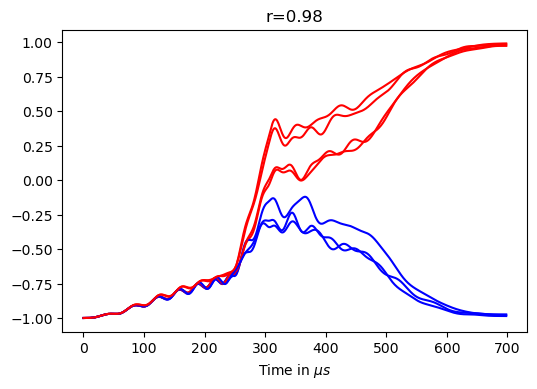

In [39]:
plot_av_occup(av_occup_for_various_ramp(REGISTER,TRY))

In [40]:
print(TRY)

[array([3156.00000383,  848.00000613, 5101.00000189]), array([3156.,  848., 5101.]), array([3156.0000005 ,  848.00000083, 5101.00000002]), array([3155.99999278,  847.99999725, 5101.00000155]), array([3156.,  848., 5101.]), array([3156.,  848., 5101.])]


## Average performance of best ramp pulse for disturbed chain

In [17]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)
def stg_mag(state):
    return sum([(-1)**j*(state.dag()*occupation(j,N)*state).tr() for j in range(N)])

In [8]:
def av_occup_for_best_ramp(K):
    E=[]
    for l in range(K):
        reg9 = reg(N,W)
        
        seq = ramp_seq(reg9, RESULT_ramp.x)
        simul = Simulation(seq, sampling_rate = 0.1)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        for j in range(N):
            E.append(expect_val)
    return np.mean(E,axis = 0)

In [29]:
E_for_best_ramp=av_occup_for_best_ramp(20)

In [24]:
def plot_av_occup(E):
    plt.figure()
    color=np.tile(['r','b'], N)
    for j in range(N):
        plt.plot(E[j],color=color[j])
    plt.xlabel('Time in '+r'$\mu s$')
    plt.title('r={:.4f}'.format(sum([(-1)**j*E[j][-1] for j in range(N)])/N))
    plt.show()
    

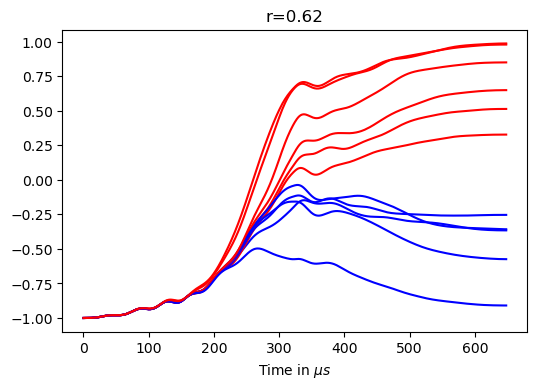

In [41]:
plot_av_occup(E_for_best_ramp)

## Ramp optimisation for each config

In [7]:
U_0 = 2 * np.pi * 2.0
Omega_max = 1.25 * U_0 
delta_0 = -2 * U_0
delta_f = 1.8 * U_0 
m = 3 
T= 7000
bounds = [(0, Omega_max)] * m + [(delta_0, delta_f)] * m
time_domain = np.linspace(0,T,T)

In [8]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
Omega_max=min([seq.declared_channels['ising'].max_amp, Omega_max])
delta_0=np.sign(delta_0)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_0)])
delta_f=np.sign(delta_f)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_f)])
print(delta_0/U_0,delta_f/U_0,Omega_max/U_0)

-2.0 1.8 1.25


In [9]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    m=len(Omega_pts)
    ti=np.linspace(0,T,m)

    cso = PchipInterpolator(ti,np.array(Omega_pts))
    csd = PchipInterpolator(ti,np.array(delta_pts))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta
def create_interp_pulse(para):
    Omega_pts = np.r_[1e-9, para[:m], 1e-9]
    delta_pts = np.r_[delta_0, para[m:], delta_f]
    Omega_func, delta_func = interp_pulse_functions(Omega_pts, delta_pts,T)
    Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))
    P=Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)
    return P
def interp_seq(reg,para):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(create_interp_pulse(para),'ising')
    return seq

def create_obs(reg,para):
    seq = interp_seq(reg,para)
    simul = Simulation(seq,sampling_rate=0.1)
    results = simul.run()
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    return expect_val

In [40]:
lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

In [53]:
def av_occup_opti(K):
    REGISTER =[]
    TRY = []
    FUN = []
    for l in range(K):
        print(l+1)
        regN = reg(N,W)
        def score(para):
            seq = interp_seq(regN,para)
            simul = Simulation(seq, sampling_rate=0.01)
            results = simul.run()
            #final = results.states[-1]
            #study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
            #sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
            #sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
            #frequencies = 0
            #if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
                #frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
            expect_val = results.expect([occupation(j,N) for j in range(N)])
            F = sum([(-1)**j*expect_val[j][-1] for j in range(N)])/N
            return (1 - F)
        t1=time.process_time()
        RESULT = gp_minimize(score, bounds, n_random_starts=30, n_calls=90, verbose=False,initial_point_generator=lhs2)
        t2=time.process_time()
        print(t2-t1)
        print(RESULT.fun)
        if RESULT.fun < 0.1:
            REGISTER.append(regN)
            FUN.append(RESULT.fun)
            TRY.append(RESULT.x)
    return REGISTER,TRY,FUN

In [ ]:
REGISTER2,TRY2,FUN2 = av_occup_opti(40)

1
240.75
0.06115823703722145
2
223.734375
0.6509058142739812
3
250.875
0.004756527821773937
4
248.140625
0.0015316014378735643
5
262.5625
0.30948617266277734
6
245.953125
0.10113421859870775
7
235.515625
0.5221398258123283
8
244.4375
0.4864863511877716
9
239.015625
0.47230394851288204
10
243.1875
0.004004718720814537
11
248.703125
0.008976982493050789
12
245.625
0.1860388799417131
13
243.53125
0.0036830000105317895
14
231.71875
0.5290387351498614
15
228.046875
0.0008600528715962952
16
253.0
0.0917481790623127
17
245.171875
0.026230319343623743
18
245.875
0.00791823413544146
19
250.421875
0.08506149985417377
20
240.90625
0.1121185354406331
21
239.703125
0.002062983588513867
22
236.578125
0.0028881347629330367
23
249.46875
0.004483176837926428
24
239.65625
0.00815901537503283
25
262.03125
0.004136652595409518
26
239.078125
0.05686031645089895
27
239.3125
0.06541050441565255
28
217.953125
0.0062158988197421605
29


In [30]:
def av_occup_for_various_interp(REGISTER,TRY):
    E=[]
    for l in range(len(REGISTER)):
        seq = interp_seq(REGISTER[l], TRY[l])
        simul = Simulation(seq, sampling_rate = 0.1)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        for j in range(N):
            E.append(expect_val)
    return np.mean(E,axis = 0)

In [31]:
def plot_av_occup(E):
    plt.figure()
    color=np.tile(['r','b'], N)
    for j in range(N):
        plt.plot(np.linspace(0,T,len(E[0])),E[j],color=color[j])
    plt.xlabel('Time in '+r'$ns$')
    plt.title(r'$\langle S(T)\rangle_W$'+'={:.3f}'.format(sum([(-1)**j*E[j][-1] for j in range(N)])/N))
    plt.show()

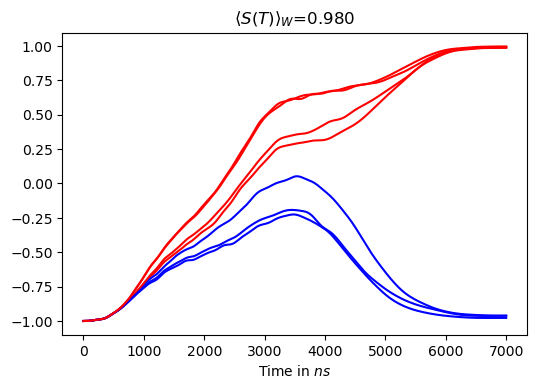

In [58]:
plot_av_occup(av_occup_for_various_interp(REGISTER2,TRY2))

In [36]:
def dist_register(reg1,reg2,j):
    x1 = reg1._coords[j][0]
    x2 = reg2._coords[j][0]
    return np.round(x1-x2,3)

In [ ]:
for j in range(N):
    print(sum([dist_register(r,REG,j) for r in REGISTER2])/len(REGISTER2))

In [ ]:
for r in REGISTER2:
    r.draw()

In [12]:
def av_occup_opti_interp(K):
    E=[]
    for l in range(K):
        print(l+1)
        regN = reg(N,W)
        def score(para):
            seq = interp_seq(regN, para)
            simul = Simulation(seq, sampling_rate=0.05)
            results = simul.run()
            final = results.states[-1]
            study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
            sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
            sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
            frequencies = 0
            if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
                frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
            return (1 - frequencies)
        RESULT = gp_minimize(score, bounds, n_random_starts=30, n_calls=60, verbose=False, kappa =4)
        print(RESULT.fun)
        print(RESULT.x)
        if RESULT.fun <=0.1:
            seq = ramp_seq(regN,RESULT.x)
            simul = Simulation(seq,sampling_rate=0.1)
            results = simul.run()
            expect_val = results.expect([occupation(j,N) for j in range(N)])
            E.append(expect_val)
    return np.mean(E,axis=0)

In [13]:
E_opt = av_occup_opti_interp(10)

1
[-0.6627442232535924, 0.6421126731825604, 0.42053895655047757, -0.10436654128818401, -0.031015131559350317, 0.47310902689084, -0.7179198971352304]
0.15900000000000003
[15.002400954490987, 6.521131887684537, 5.9188624178317175, 10.931895894893081, 22.61946710584651, 6.89864220330562]
2
[-0.3126562270985408, 0.7863235507539814, -0.7205847382112717, -0.21376635784987585, -0.7365799765497236, 0.5678696692810854, -0.6709414373353124]
0.08699999999999997
[10.730825773007952, 4.891793990736858, 1.0545903096518496, 9.09238593011014, 4.9776736190785655, 5.258186017919375]
3
[0.4526192885920124, -0.2856479965359885, 0.5554775032126589, 0.7721347984696465, -0.3567104605374596, -0.612507109883464, -0.22807996946749765]
0.049000000000000044
[15.707963267948966, 13.25836360472332, 3.3775675051389893, -12.701765550087416, 22.61946710584651, 6.559010135956953]
4
[0.413433116286138, 0.29149003013504604, -0.5215616476203693, 0.6416004611045723, -0.8119117035844072, 0.43298219323476506, 0.1544118257756

ValueError: operands could not be broadcast together with shapes (323,) (454,) 

In [ ]:
plot_av_occup(E_opt)

In [6]:
# Duration of simulation (in ns)
T= 6999
time_domain=np.linspace(0, T, T+1)

In [7]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
Omega_max=min([seq.declared_channels['ising'].max_amp, Omega_max])
delta_0=np.sign(delta_0)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_0)])
delta_f=np.sign(delta_f)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_f)])
Omega_max=seq.declared_channels['ising'].max_amp
print(Omega_max/U_0,np.round(delta_0/U_0,2),delta_f/U_0)

1.25 -1.5 1.5


In [8]:
# Size of the parameter space
m=5

# Random instance of the parameter space
para = np.r_[np.random.uniform(0,Omega_max,m),np.random.uniform(delta_0,delta_f,m)]
print(para)

[ 7.86493843  0.16842174  8.32119848 15.54188958  6.52257662  5.98482625
 -3.53518743 -5.27353528  2.94688469  4.66539965]


In [9]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    m=len(Omega_pts)
    ti=np.linspace(0,T,m)

    cso = PchipInterpolator(ti,np.array(Omega_pts))
    csd = PchipInterpolator(ti,np.array(delta_pts))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta

In [10]:
def create_interp_pulse(para):
    Omega_pts = np.r_[1e-9, para[:m], 1e-9]
    delta_pts = np.r_[delta_0, para[m:], delta_f]
    Omega_func, delta_func = interp_pulse_functions(Omega_pts, delta_pts,T)
    Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))
    P=Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)
    return P

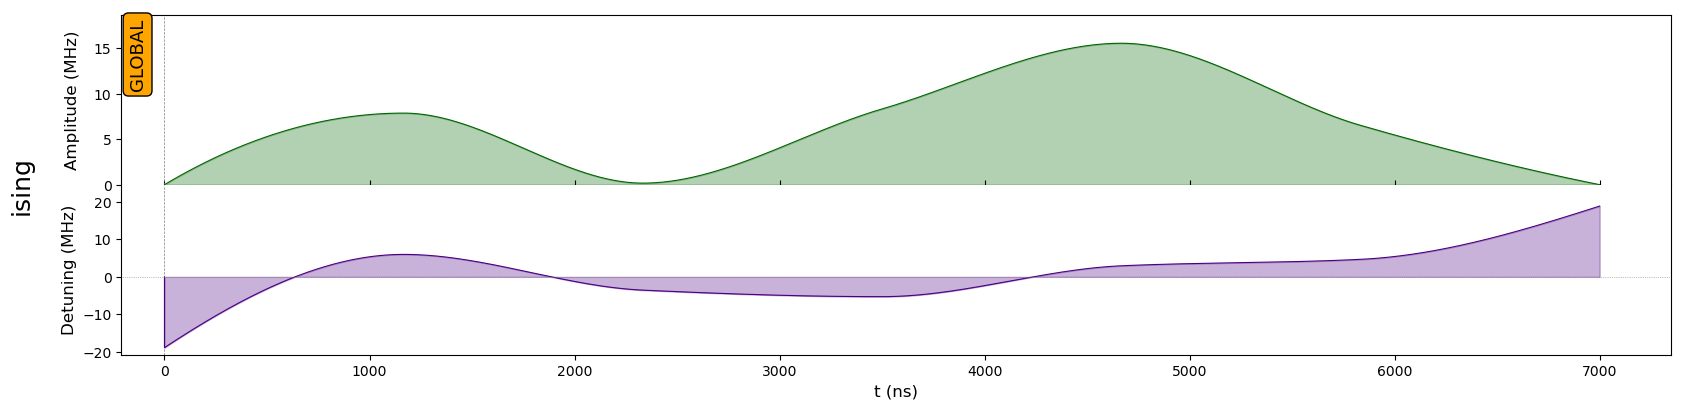

In [11]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
seq.add(create_interp_pulse(para),'ising')
seq.draw()

In [12]:
simul = Simulation(seq)
results = simul.run()
final = results.states[-1]
study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)

In [13]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)
def stg_mag(state):
    return sum([(-1)**j*(state.dag()*occupation(j,N)*state).tr() for j in range(N)])

In [14]:
from pulser.simresults import SimulationResults

def proba_from_state(state, min_p=0.1, N_samples = N_samples):
    study = SimulationResults([state], dim=2, size=N, basis_name='ground-rydberg')
    sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
    return {k: f'{100*v/study.N_samples}%' for k,v in sampling.items() if v/study.N_samples > min_p}

In [15]:
# Create antiferromagnetic state as the superposition of the two checkerboard patterns:
AF1 = qutip.tensor([qutip.basis(2,k%2) for k in range(N)])
AF2 = qutip.tensor([qutip.basis(2,(k+1)%2) for k in range(N)])
AF_state = (AF1 + AF2).unit()
print(proba_from_state(AF2))
print(proba_from_state(AF_state, min_p=0.3))

{'010101010': '100.0%'}
{'010101010': '50.7%', '101010101': '49.3%'}


In [16]:
def score(para):
    
    reg9 = reg(N,W)
    seq = Sequence(reg9, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(create_interp_pulse(para),'ising')
    
    simul = Simulation(seq, sampling_rate=0.05)
    results = simul.run()
    final = results.states[-1]
    
    study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
    sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
    sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
    
    frequencies = 0
    #if bin(2**N//3)[2:].zfill(N) in sampling.keys():
        #frequencies += sampling[bin(2**N//3)[2:].zfill(N)]/N_samples
    if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
        frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
    
    #F = qutip.fidelity(sampled_state,AF1)
    #F = stg_mag(sampled_state)/N
    #print(1-F)
    return (1 - frequencies)

In [17]:
N_repet = 1
def score_av(para):
    F_tot = 0
    for k in range(N_repet):
        reg9 = reg(N,W)
        seq = Sequence(reg9, Chadoq2)
        seq.declare_channel('ising', 'rydberg_global')
        seq.add(create_interp_pulse(para),'ising')

        simul = Simulation(seq, sampling_rate=0.05)
        results = simul.run()
        final = results.states[-1]

        study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
        sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
        sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
        frequencies = 0
        if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
            frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
        F_tot+=frequencies
        
    F_tot=F_tot/N_repet
    #stg_mag(sampled_state)/N
    return (1 - F_tot)/2

In [18]:
para = np.r_[np.random.uniform(0,Omega_max,m),np.random.uniform(delta_0,delta_f,m)]
print(score(para))
print(score_av(para))

0.956
0.4246


In [19]:
bounds = [(0.0, Omega_max)] * m + [(delta_0, delta_f)] * m
bounds=[(Omega_max*i/(m//2+1),Omega_max*(i+1)/(m//2+1)) for i in range(m//2+1)]+[(Omega_max*i/(m//2+1),Omega_max*(i+1)/(m//2+1)) for i in range(m//2-1,-1,-1)]+[(delta_0+i*(delta_f-delta_0)/m,delta_0+(i+1)*(delta_f-delta_0)/m) for i in range(m)]


In [150]:
n_r = 40
n_c = 120

RESULT = gp_minimize(score, bounds, n_random_starts=n_r, n_calls=n_c, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6700
Function value obtained: 0.9770
Current minimum: 0.9770
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2918
Function value obtained: 1.0000
Current minimum: 0.9770
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6349
Function value obtained: 0.9980
Current minimum: 0.9770
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3936
Function value obtained: 0.1790
Current minimum: 0.1790
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4564
Function value obtained: 0.9960
Current minimum: 0.1790
Iteration No: 6 started. Evaluating

In [151]:
def sort_improv(RESULT):
    score_vals = RESULT.func_vals
    min = score_vals[0]
    score_list=[]
    for s in score_vals:
        if s<min:
            min=s
            score_list.append(min)
        else:
            score_list.append(min)
    return score_list

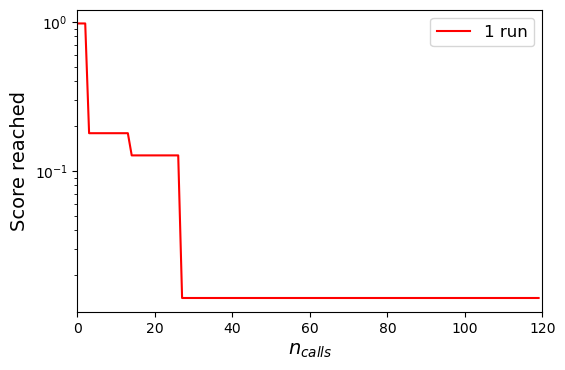

In [152]:
fig = plt.figure()
plt.semilogy(range(n_c), sort_improv(RESULT), 'r-')
plt.xlabel(r'$n_{calls}$', fontsize=14)
plt.ylabel('Score reached', fontsize=14)
plt.legend(['1 run'],fontsize=12)
plt.xlim(0,n_c)
plt.show()

In [155]:
score_av(RESULT.x)

0.40990000000000004

In [156]:
def av_occup(K):
    E=[np.array([0]*(T+1))]*N
    for l in range(K):
        reg9 = reg(N,W)
        
        seq = Sequence(reg9, Chadoq2)
        seq.declare_channel('ising', 'rydberg_global')
        P = create_interp_pulse(RESULT.x)
        seq.add(P,'ising')
        simul = Simulation(seq)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        for j in range(N):
            E[j]=np.add(E[j],expect_val[j]/K)
    return E

In [157]:
E = av_occup(20)

In [22]:
def av_occup_opti(K):
    for l in range(K):
        print(l+1)
        regN = reg(N,W)
        def score(para):
            seq = interp_seq(regN,para)
            simul = Simulation(seq, sampling_rate=0.2)
            results = simul.run()
            final = results.states[-1]
            study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
            sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
            sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
            frequencies = 0
            if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
                frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
            return (1 - frequencies)
        RESULT = gp_minimize(score, bounds, n_random_starts=30, n_calls=60, verbose=False)
        print(RESULT.fun)
        if RESULT.fun < 0.05:
            REGISTER.append(regN)
            FUN.append(RESULT.fun)
            TRY.append(RESULT.x)
    return REGISTER,TRY,FUN

In [23]:
E_opt = av_occup_opti(10)

0
0.02400000000000002
1
0.15700000000000003
2


C:\Users\asus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\asus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\asus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\asus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\asus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\asus\anacon

0.698
3
0.09299999999999997
4
0.377
5
0.251
6
0.44399999999999995
7
0.007000000000000006
8
0.44999999999999996
9
0.0010000000000000009


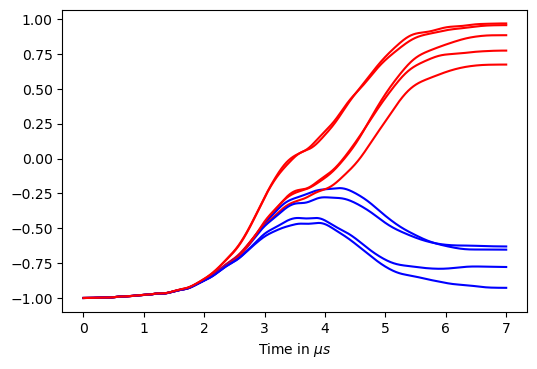

In [24]:
plt.figure()
color=np.tile(['r','b'], N)
for j in range(N):
    plt.plot([t/1000 for t in time_domain],E_opt[j],color=color[j])
plt.xlabel('Time in '+r'$\mu s$' )
plt.show()

In [25]:
print(sum([(-1)**j*E_opt[j][-1] for j in range(N)])/N)

0.8049528736322542


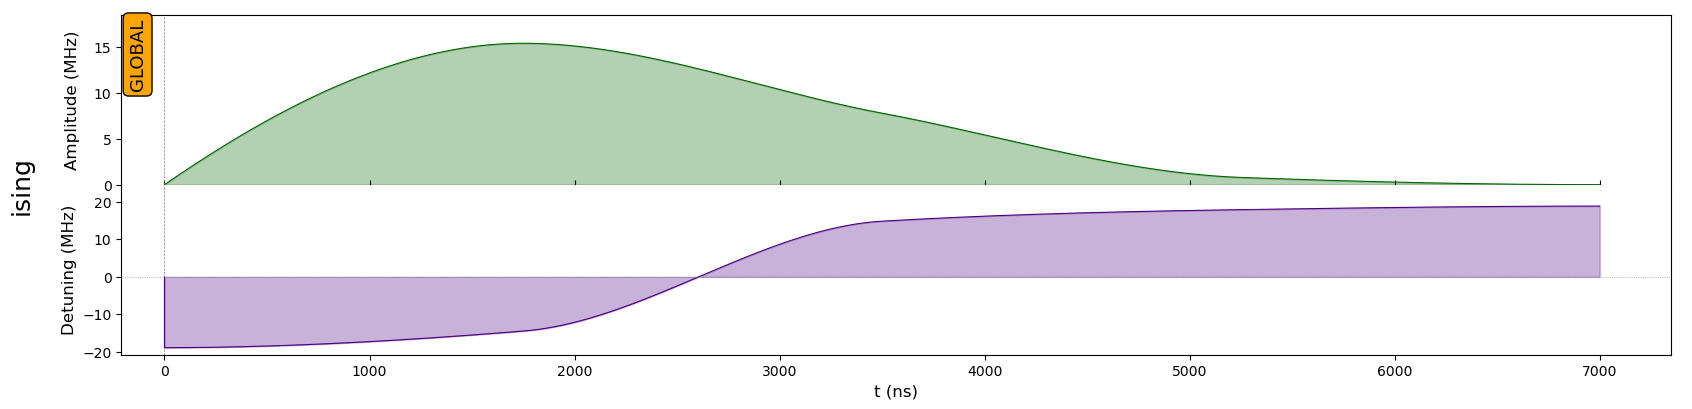

In [163]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
P = create_interp_pulse(RESULT.x)
seq.add(P,'ising')
seq.draw()

In [164]:
simul = Simulation(seq)
results = simul.run()
expect_val = results.expect([occupation(j,N) for j in range(N)])
final = results.states[-1]
study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)


In [165]:
print(proba_from_state(final, min_p=0.05))

{'101010101': '98.5%'}


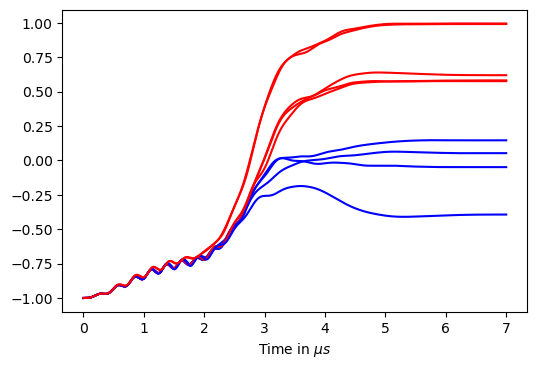

In [161]:
plt.figure()
color=np.tile(['r','b'], N)
for j in range(N):
    plt.plot([t/1000 for t in time_domain],E[j],color=color[j])
plt.xlabel('Time in '+r'$\mu s$' )
plt.show()

In [ ]:
def av_occup(K):
    E=[np.array([0]*(T+1))]*N
    for l in range(K):
        reg9 = reg(N,W)
        
        seq = Sequence(reg9, Chadoq2)
        seq.declare_channel('ising', 'rydberg_global')
        P = create_interp_pulse(RESULT.x)
        seq.add(P,'ising')
        simul = Simulation(seq)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        for j in range(N):
            E[j]=np.add(E[j],expect_val[j]/K)
    return E

In [79]:
N = 11

Omega_max = 1.3 * 2*np.pi 
U_0 = 2*np.pi*3

delta_0 = -2 * 2*np.pi 
delta_f = 1.8 * 2*np.pi 

t_rise = 1000
t_fall = 1000
t_sweep = 4500

R_interatomic = Chadoq2.rydberg_blockade_radius(U_0)
def reg(N, W):
    U =  [U_0 * (1 + np.random.uniform(-W, W)) for _ in range(N)]

    def R(j):
        return Chadoq2.rydberg_blockade_radius(U[j]) 

    # Build Register:

    coords = np.array([(sum(R(k) for k in range(i)), 0.) for i in range(N)])
    return Register.from_coordinates(coords, prefix='atom')
REG = reg (N,0)
reg9 = reg(N,W)
T= t_rise+t_fall+int(t_sweep)
time_domain=np.linspace(0, T, T)

In [80]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

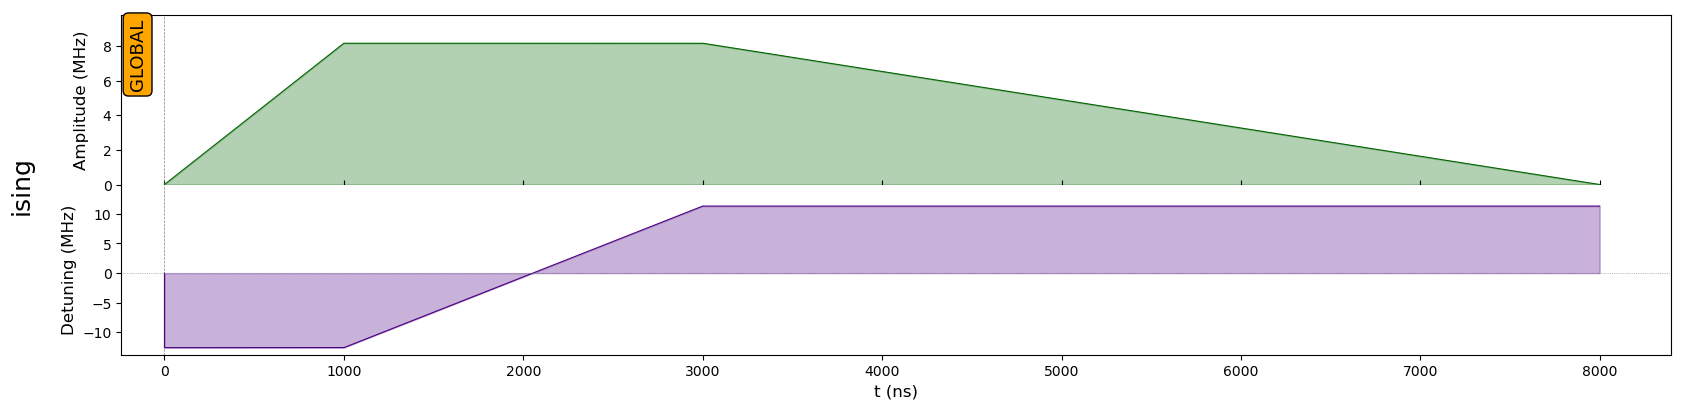

In [81]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')
seq.draw()

In [29]:
simul = Simulation(seq)
results = simul.run()
expect_val = results.expect([occupation(j,N) for j in range(N)])
final = results.states[-1]
study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)

In [30]:
print(proba_from_state(final, min_p=0.1))

{'10101010101': '96.9%'}


In [64]:
def av_occup_ramp(K):
    sampling_rate = 0.2 
    E=[np.array([0]*int(T*sampling_rate))]*N
    rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
    sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
    fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
    for l in range(K):
        reg9 = reg(N,W)
        seq = Sequence(reg9, Chadoq2)
        seq.declare_channel('ising', 'rydberg_global')
        seq.add(rise, 'ising')
        seq.add(sweep, 'ising')
        seq.add(fall, 'ising')
        simul = Simulation(seq, sampling_rate=sampling_rate)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        for j in range(N):
            E[j]=np.add(E[j],expect_val[j]/K)
    return E

In [65]:
E_ramp = av_occup_ramp(100)

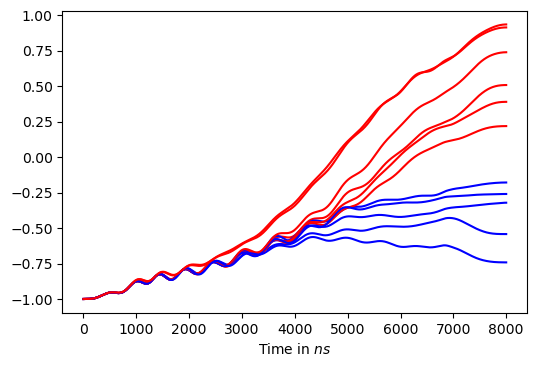

In [147]:
plt.figure()
color=np.tile(['r','b'], N)
for j in range(N):
    plt.plot(np.linspace(0,T,1300),E_ramp[j],color=color[j])
plt.xlabel('Time in '+r'$n s$' )
plt.show()

In [140]:
print(sum([(-1)**j*E_ramp[j][-1] for j in range(N)])/N)

0.5225710560319737


In [120]:
print(T)

8000


In [135]:
def av_occup_opti_ramp(K):
    E=[]
    for l in range(K):
        print(l)
        reg9 = reg(N,W)
        def score(para):
            para.sort()
            seq = Sequence(reg9, Chadoq2)
            seq.declare_channel('ising', 'rydberg_global')
            t_rise = int(para[0]*T/sum(para))
            t_sweep = int(para[1]*T/sum(para))
            t_fall = int(para[2]*T/sum(para))
            rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
            sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
            fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
            seq.add(rise, 'ising')
            seq.add(sweep, 'ising')
            seq.add(fall, 'ising')
            simul = Simulation(seq, sampling_rate=0.1)
            results = simul.run()
            final = results.states[-1]
            study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
            sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
            sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
            frequencies = 0
            if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
                frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
            return (1 - frequencies)
        RESULT = gp_minimize(score, [(48,T)]*3, n_random_starts=30, n_calls=60, verbose=False)
        print(RESULT.fun)
        print(RESULT.x)
        seq = Sequence(reg9, Chadoq2)
        seq.declare_channel('ising', 'rydberg_global')
        para = RESULT.x
        t_rise = int(para[0]*T/sum(para))
        t_sweep = int(para[1]*T/sum(para))
        t_fall = int(para[2]*T/sum(para))
        rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
        sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
        fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
        seq.add(rise, 'ising')
        seq.add(sweep, 'ising')
        seq.add(fall, 'ising')
        simul = Simulation(seq,sampling_rate=0.1)
        results = simul.run()
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        E.append(expect_val)
    return np.mean(E,axis=0)

In [136]:
Ero=av_occup_opti_ramp(10)

0
0.05900000000000005
[2099, 5462, 6970]
1
0.10699999999999998
[1802, 2460, 8000]
2
0.006000000000000005
[1335, 2604, 2656]
3
0.061000000000000054
[1226, 3413, 5913]
4
0.015000000000000013
[805, 2259, 4539]
5
0.027000000000000024
[1685, 3020, 4074]
6
0.577
[4825, 5080, 6478]
7
0.009000000000000008
[3354, 4138, 4188]
8
0.8009999999999999
[568, 762, 7998]
9
0.041000000000000036
[1931, 6024, 6224]


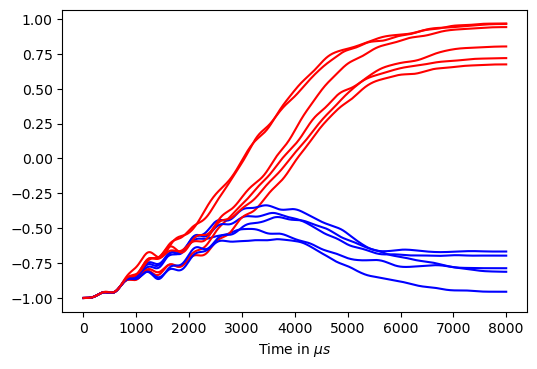

In [148]:
plt.figure()
color=np.tile(['r','b'], N)
for j in range(N):
    plt.plot(np.linspace(0,T,len(Ero[0])),Ero[j],color=color[j])
plt.xlabel('Time in '+r'$\mu s$' )
plt.show()

In [138]:
print(sum([(-1)**j*Ero[j][-1] for j in range(N)])/N)

0.8170180659582919


In [94]:
reg9 = reg(N,W)
def score(para):
    para.sort()
    seq = Sequence(reg9, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    t_rise = int(para[0]*T)
    t_sweep = int(para[1]*T)-int(para[0]*T)
    t_fall = T - t_sweep - t_rise
    rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
    sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
    fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
    seq.add(rise, 'ising')
    seq.add(sweep, 'ising')
    seq.add(fall, 'ising')
    simul = Simulation(seq, sampling_rate=0.01)
    results = simul.run()
    final = results.states[-1]
    study = SimulationResults([final], dim=2, size=N, basis_name='ground-rydberg')
    sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=N_samples)
    sampled_state = sum([np.sqrt(sampling[k]/N_samples)*qutip.ket(k) for k in sampling.keys()])
    frequencies = 0
    if bin(2*2**N//3)[2:].zfill(N) in sampling.keys():
        frequencies += sampling[bin(2*2**N//3)[2:].zfill(N)]/N_samples
    return (1 - frequencies)
RESULT = gp_minimize(score, [(0.005,0.995)]*2, n_random_starts=15, n_calls=30, verbose=True)
print(RESULT.fun)
seq = Sequence(reg9, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
para = RESULT.x
t_rise = int(para[0]*T)
t_sweep = int(para[1]*T)-int(para[0]*T)
t_fall = T - t_sweep - t_rise
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')
simul = Simulation(seq)
results = simul.run()
expect_val = results.expect([occupation(j,N) for j in range(N)])

C:\Users\asus\github\Pulser\pulser\utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"
C:\Users\asus\github\Pulser\pulser\utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"
C:\Users\asus\github\Pulser\pulser\utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"
C:\Users\asus\github\Pulser\pulser\utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below t

0.03500000000000003


C:\Users\asus\github\Pulser\pulser\utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"


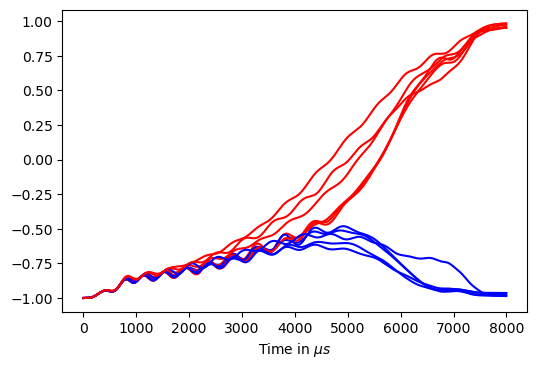

In [118]:
plt.figure()
color=np.tile(['r','b'], N)
for j in range(N):
    plt.plot(expect_val[j],color=color[j])
plt.xlabel('Time in '+r'$\mu s$' )
plt.show()

In [119]:
print(sum([(-1)**j*expect_val[j][-1] for j in range(N)])/N)

0.9710929223607511


In [111]:
EE = [expect_val]*10
EEE = np.mean(EE, axis = 0)

In [114]:
EE.append(expect_val)

In [5]:
[REG._coords[i][0] for i in range(N)]

[-25.735975547601477,
 -17.157317031734316,
 -8.578658515867158,
 0.0,
 8.578658515867161,
 17.157317031734323,
 25.735975547601484]

In [16]:
def W_from_register(register):
    x_list = [register._coords[i][0] for i in range(N)]
    diff_list = [(5008713/(abs(x_list[i]-x_list[i+1]))**6)/U_0-1 for i in range(N-1)]
    return diff_list

In [17]:
W_list=[W_from_register(r) for r in RL]

NameError: name 'RL' is not defined

In [18]:
print(sum(np.mean(W_list,axis=0))/N)
print(sum(np.var(W_list,axis=0))/N-(2*W)**2/12)

NameError: name 'W_list' is not defined